# Task 3 ZNE


Zero-noise extrapolation (ZNE) is a noise mitigation technique. It works by intentionally scaling the noise of a quantum circuit to then extrapolate the zero-noise limit of an observable of interest. In this task, you will build a simple ZNE function from scratch:

1) Build a simple noise model with depolarizing noise 
2) Create different circuits to test your noise models and choose the observable to measure 
3) Apply the unitary folding method. 
4) Apply the extrapolation method to get the zero-noise limit. Different extrapolation methods achieve different results, such as Linear, polynomial, and exponential.
5) Compare mitigated and unmitigated results 
6) Bonus: Run your ZNE function in real quantum hardware through the IBM Quantum Service

Check the Mitiq documentation for references. You are not allowed to use the functions from Mitiq or any other frameworks where ZNE is already implemented. 

# 1) Simple Noise Model with Depolarizing Noise
A noise model simulates the effect of errors in quantum computations. 

Qiskit provides a noise model that includes depolarizing noise.

In [1]:
from qiskit_aer.noise import NoiseModel, depolarizing_error
from qiskit.visualization import plot_histogram
from qiskit_aer import AerSimulator
from qiskit import transpile, assemble


def build_noise_model(depolarizing_error_prob, num_qubits):
    noise_model = NoiseModel() #  Initializes an empty noise model.
    depol_error = depolarizing_error(depolarizing_error_prob, num_qubits)
    noise_model.add_all_qubit_quantum_error(depol_error, ['u1', 'u2', 'u3', 'cx'])
    return noise_model

* The function that takes two parameters: `depolarizing_error_prob`, which is the probability of a depolarizing error occurring on each gate, and `num_qubits`, which is the number of qubits in the quantum circuit. 
* The `depolarizing_error` creates a depolarizing error object that affects all qubits with a given probability depolarizing_error_prob.
* Finally `.add_all_qubit_quantum_error(depol_error, ['u1', 'u2', 'u3', 'cx'])`: Adds the depolarizing error to all qubits for the specified gates. The gates 'u1', 'u2', and 'u3' represent all single-qubit rotations, and 'cx' represents the CNOT gate, a common two-qubit gate.
* The function returns the constructed noise model, which can be used in a simulation to model the effects of noise on a quantum circuit.

Example of aplication:
```
noise_model = build_noise_model(error_prob, num_qubits)
circuit = create_circuit()
transpiled_circuit = transpile(circuit, basis_gates=noise_model.basis_gates)
simulator = AerSimulator(noise_model=my_noise_model)
```



# 2) Create Different Circuits and Choose an Observable

To test the noise models, let create a variety of quantum circuits that are sensitive to different types of noise and then choose an observable that will help measure the impact of that noise. 

a) **Simple single-qubit circuit**

Applies a Hadamard gate to the first qubit and choose as observable the expectation value of the Pauli-Z operator on a qubit.

In [3]:
from qiskit import QuantumCircuit, transpile
from qiskit_aer import Aer
from qiskit.quantum_info import Pauli, Statevector, Operator

In [1]:
def create_circuit():
    qc = QuantumCircuit(1)
    qc.h(0)
    return qc

In [11]:
simple_circuit = create_circuit()
simple_circuit.draw()

┌───┐
q: ┤ H ├
   └───┘

In [5]:
# Assume the observable care about is the expectation value of the Z operator on the first qubit.
observable = Operator(Pauli('Z'))

b) **Bell State Circuit:**

Creating entangled states like Bell states is sensitive to errors because entanglement is a delicate property.

In [6]:
def bell_state_circuit():
    qc = QuantumCircuit(2)
    qc.h(0)
    qc.cx(0, 1)
    return qc

In [12]:
bell_circuit = bell_state_circuit()
bell_circuit.draw()

┌───┐     
q_0: ┤ H ├──■──
     └───┘┌─┴─┐
q_1: ─────┤ X ├
          └───┘

Here for the measure is interesting the parity of the two qubits in the Bell state, which can be measured using the ZZ operator.

In [9]:
observable_bell = Operator(Pauli('ZZ'))


c) **GHZ State Circuit:**

Larger entangled states amplify errors further, making the GHZ state a good test.

In [7]:
def ghz_state_circuit(num_qubits):
    qc = QuantumCircuit(num_qubits)
    qc.h(0)
    for qubit in range(num_qubits - 1):
        qc.cx(qubit, qubit + 1)
    return qc

In [15]:
num_qubits = 3
ghz_3_qubit_circuit = ghz_state_circuit(num_qubits)
ghz_3_qubit_circuit.draw()

┌───┐          
q_0: ┤ H ├──■───────
     └───┘┌─┴─┐     
q_1: ─────┤ X ├──■──
          └───┘┌─┴─┐
q_2: ──────────┤ X ├
               └───┘

For GHZ State, it might measure the parity of all qubits, using an observable like ZZZ...Z (one Z for each qubit).

In [16]:
observable_ghz = Operator(Pauli('Z' * num_qubits))

# 3) Apply the unitary folding method. 
Unitary folding is a technique used in the context of quantum error mitigation, specifically as part of the zero-noise extrapolation (ZNE) method. The idea behind unitary folding is to artificially increase the noise in a quantum circuit to observe its behavior under different noise levels and then extrapolate the results to estimate what they would be with no noise. The process involves "folding" parts of the circuit back on themselves, effectively doubling the noise on those operations without changing the ideal outcome of the circuit.

*How to Apply Unitary Folding*
Unitary folding involves selecting parts of the quantum circuit and then appending their inverses, effectively canceling them out in the ideal, noise-free case but doubling the noise they introduce. Here's a general approach to applying unitary folding:

* **Identify the Folding Point:** Decide which part of the circuit you want to fold. This could be the entire circuit or specific gates within it.

* **Fold the Circuit:** For each gate (or the entire set of gates) you want to fold, append the inverse of those gates in reverse order immediately after them.

* **Scale Factor:** The amount of folding applied can be controlled by a scale factor. A scale factor of 1 means no folding, 2 means folding the entire circuit once (effectively doubling its depth), and so on.

Let's consider a simple function to fold a circuit, focusing on folding the entire circuit for simplicity.

In [17]:
def fold_circuit(circuit, scale_factor):
    """
    Folds a circuit by a given scale factor. Scale factor <= 1 means no folding.
    Only supports whole-circuit folding for simplicity.

    Parameters:
    circuit (QuantumCircuit): The original quantum circuit.
    scale_factor (float): The factor by which to scale the noise, should be >= 1.

    Returns:
    QuantumCircuit: The folded quantum circuit.
    """
    if scale_factor <= 1:
        return circuit  # No folding needed for scale factor of 1 or less
    
    # Calculate the number of folds needed, rounded down
    num_folds = int(scale_factor - 1)
    
    folded_circuit = circuit.copy()
    
    # Fold the circuit the required number of times
    for _ in range(num_folds):
        # Iterate over the circuit in reverse order and append the inverse
        for gate in reversed(circuit.data):
            # Get the gate name and qubits it acts on
            gate_name = gate[0].name
            qubits = gate[1]
            # Append the inverse gate
            folded_circuit.append(gate[0].inverse(), qubits)
            # Append the original gate again to "cancel out" in an ideal, noise-free scenario
            folded_circuit.append(gate[0], qubits)
            
    return folded_circuit


This function doubles the circuit's depth by folding it, effectively increasing the noise if run on a noisy backend or with a noise model. The approach shown here is simplistic and intended for illustration. More sophisticated folding techniques might selectively fold specific gates or parts of a circuit to better mimic the noise behavior of real quantum hardware.



### Examples with the example circuits

In [18]:
# Example: Apply folding with a scale factor of 3
folded_simple_circuit = fold_circuit(simple_circuit, 3)
folded_simple_circuit.draw()

┌───┐┌───┐┌───┐┌───┐┌───┐
q: ┤ H ├┤ H ├┤ H ├┤ H ├┤ H ├
   └───┘└───┘└───┘└───┘└───┘

In [20]:
folded_bell_circuit = fold_circuit(bell_circuit, 2)
folded_bell_circuit.draw()

┌───┐               ┌───┐┌───┐
q_0: ┤ H ├──■────■────■──┤ H ├┤ H ├
     └───┘┌─┴─┐┌─┴─┐┌─┴─┐└───┘└───┘
q_1: ─────┤ X ├┤ X ├┤ X ├──────────
          └───┘└───┘└───┘

In [21]:
folded_factor_3_bell_circuit = fold_circuit(bell_circuit, 3)
folded_factor_3_bell_circuit.draw()

┌───┐               ┌───┐┌───┐          ┌───┐┌───┐
q_0: ┤ H ├──■────■────■──┤ H ├┤ H ├──■────■──┤ H ├┤ H ├
     └───┘┌─┴─┐┌─┴─┐┌─┴─┐└───┘└───┘┌─┴─┐┌─┴─┐└───┘└───┘
q_1: ─────┤ X ├┤ X ├┤ X ├──────────┤ X ├┤ X ├──────────
          └───┘└───┘└───┘          └───┘└───┘

In [22]:
fold_ghz_3_qubit_circuit = fold_circuit(ghz_3_qubit_circuit, 2)
fold_ghz_3_qubit_circuit.draw()

┌───┐                              ┌───┐┌───┐
q_0: ┤ H ├──■───────────────────■────■──┤ H ├┤ H ├
     └───┘┌─┴─┐               ┌─┴─┐┌─┴─┐└───┘└───┘
q_1: ─────┤ X ├──■────■────■──┤ X ├┤ X ├──────────
          └───┘┌─┴─┐┌─┴─┐┌─┴─┐└───┘└───┘          
q_2: ──────────┤ X ├┤ X ├┤ X ├────────────────────
               └───┘└───┘└───┘

### Simulate both the original and the folded circuit with a noise model:

In [23]:
# Define a noise model
depolarizing_error_prob = 0.01
noise_model = build_noise_model(depolarizing_error_prob, 1)

NoiseError: '1 qubit QuantumError cannot be applied to 2 qubit instruction "cx".'

In [25]:
# Define a noise model
depolarizing_error_prob = 0.01
noise_model = build_noise_model(depolarizing_error_prob, 2)

NoiseError: '2 qubit QuantumError cannot be applied to 1 qubit instruction "u1".'

## Lets Fix the `build_noise_model()` for 1-qubit and 2-qubit gates

In [45]:
def build_noise_model(depolarizing_error_prob):
    noise_model = NoiseModel()
    
    # Create depolarizing error models for 1-qubit and 2-qubit gates
    depol_error_1q = depolarizing_error(depolarizing_error_prob, 1)
    depol_error_2q = depolarizing_error(depolarizing_error_prob, 2)
    
    # Apply the single-qubit depolarizing error model to single-qubit gates
    noise_model.add_all_qubit_quantum_error(depol_error_1q, ['u1', 'u2', 'u3'])
    
    # Apply the two-qubit depolarizing error model to two-qubit gates
    noise_model.add_all_qubit_quantum_error(depol_error_2q, ['cx'])
    
    return noise_model


### Return to Simulate both the original and the folded circuit with a noise model:

* simple_circuit

In [42]:
simple_circuit = create_circuit()
simple_circuit.draw()

┌───┐
q: ┤ H ├
   └───┘

In [43]:
folded_simple_circuit = fold_circuit(simple_circuit, 3)
folded_simple_circuit.draw()

┌───┐┌───┐┌───┐┌───┐┌───┐
q: ┤ H ├┤ H ├┤ H ├┤ H ├┤ H ├
   └───┘└───┘└───┘└───┘└───┘

In [46]:
# Define a noise model (from previous steps)
depolarizing_error_prob = 0.01
noise_model = build_noise_model(depolarizing_error_prob)

Original Circuit Counts: {'0': 513, '1': 511}
Folded Circuit Counts: {'1': 496, '0': 528}


/var/folders/rh/r7s1vfq50cj305_qp12kpvk00000gn/T/ipykernel_837/1993500261.py:7: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job_original = simulator.run(qobj_original)
/var/folders/rh/r7s1vfq50cj305_qp12kpvk00000gn/T/ipykernel_837/1993500261.py:15: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job_folded = simulator.run(qobj_folded)


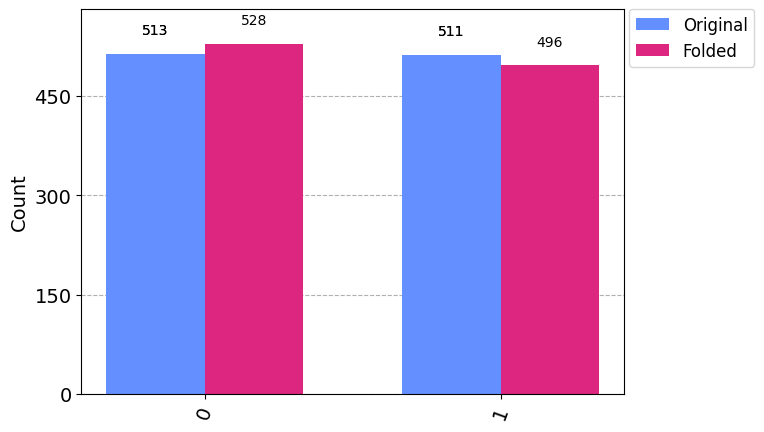

In [47]:
simulator = AerSimulator(noise_model=noise_model)

# Simulate the original circuit
simple_circuit.measure_all()
transpiled_circuit = transpile(simple_circuit, simulator)
qobj_original = assemble(transpiled_circuit, simulator, shots=1024)
job_original = simulator.run(qobj_original)
result_original = job_original.result()
counts_original = result_original.get_counts(simple_circuit)

# Simulate the folded circuit
folded_simple_circuit.measure_all()
transpiled_folded_circuit = transpile(folded_simple_circuit, simulator)
qobj_folded= assemble(transpiled_folded_circuit, simulator, shots=1024)
job_folded = simulator.run(qobj_folded)
result_folded = job_folded.result()
counts_folded = result_folded.get_counts(simple_circuit)

# Display the results
print("Original Circuit Counts:", counts_original)
print("Folded Circuit Counts:", counts_folded)
plot_histogram([counts_original, counts_folded], legend=['Original', 'Folded'])

`measure_all()` is for getting the probabilities of each computational basis state after running the circuit, 

while measuring an observable like `Pauli-Z` is for getting the expectation value (the average outcome) of that observable in the state produced by your circuit.

In [87]:
def measure_observable(circuit, observable, noise_model=None):
    backend = Aer.get_backend('qasm_simulator')
    circuit.save_statevector()
    transpiled_circuit = transpile(circuit, backend)
    job = backend.run(transpiled_circuit, noise_model=noise_model)
    result = job.result()
    state = Statevector(result.get_statevector(circuit))
    expectation_value = state.expectation_value(observable)
    return expectation_value.real

In [89]:
simple_circuit = create_circuit()
simple_observable = Operator(Pauli('Z'))
depolarizing_error_prob = 0.01
noise_model = build_noise_model(depolarizing_error_prob)

In [90]:
measure_observable(simple_circuit, simple_observable, noise_model)

2.220446049250313e-16

In [91]:
simple_circuit.draw()

┌───┐ statevector 
q: ┤ H ├──────░──────
   └───┘      ░

In [92]:
simple_circuit = create_circuit()
folded_simple_circuit = fold_circuit(simple_circuit, 3)
folded_simple_circuit.draw()


┌───┐┌───┐┌───┐┌───┐┌───┐
q: ┤ H ├┤ H ├┤ H ├┤ H ├┤ H ├
   └───┘└───┘└───┘└───┘└───┘

In [93]:
measure_observable(folded_simple_circuit, simple_observable, noise_model)

2.220446049250313e-16

* bell_circuit

In [48]:
bell_circuit = bell_state_circuit()
bell_circuit.draw()

┌───┐     
q_0: ┤ H ├──■──
     └───┘┌─┴─┐
q_1: ─────┤ X ├
          └───┘

In [49]:
folded_bell_circuit = fold_circuit(bell_circuit, 2)
folded_bell_circuit.draw()

┌───┐               ┌───┐┌───┐
q_0: ┤ H ├──■────■────■──┤ H ├┤ H ├
     └───┘┌─┴─┐┌─┴─┐┌─┴─┐└───┘└───┘
q_1: ─────┤ X ├┤ X ├┤ X ├──────────
          └───┘└───┘└───┘

Original Circuit Counts: {'01': 6, '10': 2, '11': 514, '00': 502}
Folded Circuit Counts: {'01': 1, '10': 3, '00': 542, '11': 478}


/var/folders/rh/r7s1vfq50cj305_qp12kpvk00000gn/T/ipykernel_837/2618326249.py:11: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job_bell_circuit_original = simulator.run(qobj_bell_circuit_original)
/var/folders/rh/r7s1vfq50cj305_qp12kpvk00000gn/T/ipykernel_837/2618326249.py:19: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job_folded_bell_circuit = simulator.run(qobj_folded_bell_circuit)


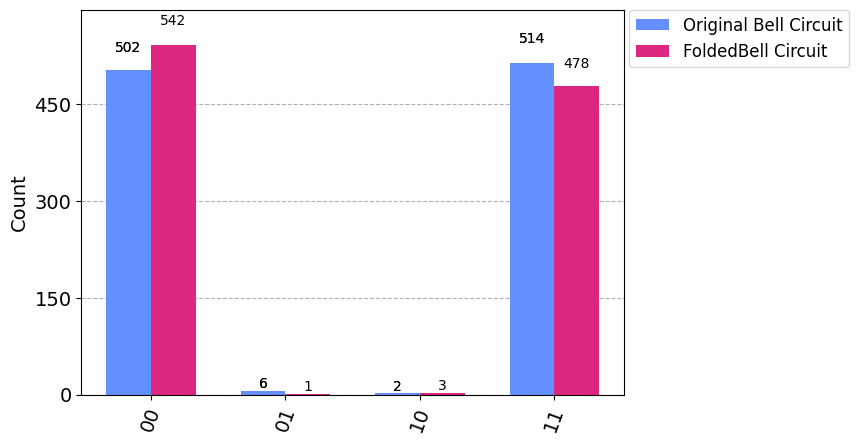

In [50]:
# Define a noise model (from previous steps)
depolarizing_error_prob = 0.01
noise_model = build_noise_model(depolarizing_error_prob)

simulator = AerSimulator(noise_model=noise_model)

# Simulate the original circuit
bell_circuit.measure_all()
transpiled_bell_circuit = transpile(bell_circuit, simulator)
qobj_bell_circuit_original = assemble(transpiled_bell_circuit, simulator, shots=1024)
job_bell_circuit_original = simulator.run(qobj_bell_circuit_original)
result_bell_circuit_original = job_bell_circuit_original.result()
counts_bell_circuit_original = result_bell_circuit_original.get_counts(bell_circuit)

# Simulate the folded circuit
folded_bell_circuit.measure_all()
transpiled_folded_bell_circuit = transpile(folded_bell_circuit, simulator)
qobj_folded_bell_circuit= assemble(transpiled_folded_bell_circuit, simulator, shots=1024)
job_folded_bell_circuit = simulator.run(qobj_folded_bell_circuit)
result_folded_bell_circuit = job_folded_bell_circuit.result()
counts_folded_bell_circuit = result_folded_bell_circuit.get_counts(folded_bell_circuit)

# Display the results
print("Original Circuit Counts:", counts_bell_circuit_original)
print("Folded Circuit Counts:", counts_folded_bell_circuit)
plot_histogram([counts_bell_circuit_original, counts_folded_bell_circuit], legend=['Original Bell Circuit', 'FoldedBell Circuit'])

With Observable

In [95]:
bell_circuit = bell_state_circuit()
observable_bell = Operator(Pauli('ZZ'))
depolarizing_error_prob = 0.01
noise_model = build_noise_model(depolarizing_error_prob)

In [96]:
measure_observable(bell_circuit, observable_bell, noise_model)

1.0

In [97]:
bell_circuit.draw()

┌───┐      statevector 
q_0: ┤ H ├──■────────░──────
     └───┘┌─┴─┐      ░      
q_1: ─────┤ X ├──────░──────
          └───┘      ░

In [99]:
bell_circuit = bell_state_circuit()
folded_bell_circuit = fold_circuit(bell_circuit, 2)
measure_observable(folded_bell_circuit, observable_bell, noise_model)

1.0

In [100]:
folded_bell_circuit.draw()

┌───┐               ┌───┐┌───┐ statevector 
q_0: ┤ H ├──■────■────■──┤ H ├┤ H ├──────░──────
     └───┘┌─┴─┐┌─┴─┐┌─┴─┐└───┘└───┘      ░      
q_1: ─────┤ X ├┤ X ├┤ X ├────────────────░──────
          └───┘└───┘└───┘                ░

* ghz_3_qubit_circuit

In [53]:
num_qubits = 3
ghz_3_qubit_circuit = ghz_state_circuit(num_qubits)
ghz_3_qubit_circuit.draw()
folded_ghz_3_qubit_circuit = fold_circuit(ghz_3_qubit_circuit, 2)
folded_ghz_3_qubit_circuit.draw()

┌───┐                              ┌───┐┌───┐
q_0: ┤ H ├──■───────────────────■────■──┤ H ├┤ H ├
     └───┘┌─┴─┐               ┌─┴─┐┌─┴─┐└───┘└───┘
q_1: ─────┤ X ├──■────■────■──┤ X ├┤ X ├──────────
          └───┘┌─┴─┐┌─┴─┐┌─┴─┐└───┘└───┘          
q_2: ──────────┤ X ├┤ X ├┤ X ├────────────────────
               └───┘└───┘└───┘

Original Circuit Counts: {'001': 3, '110': 3, '100': 2, '111': 511, '101': 1, '000': 504}
Folded Circuit Counts: {'001': 5, '011': 2, '110': 1, '000': 531, '111': 485}


/var/folders/rh/r7s1vfq50cj305_qp12kpvk00000gn/T/ipykernel_837/3148154548.py:11: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job_ghz_3_qubit_circuit = simulator.run(qobj_ghz_3_qubit_circuit)
/var/folders/rh/r7s1vfq50cj305_qp12kpvk00000gn/T/ipykernel_837/3148154548.py:19: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job_folded_ghz_3_qubit_circuit = simulator.run(qobj_folded_ghz_3_qubit_circuit)


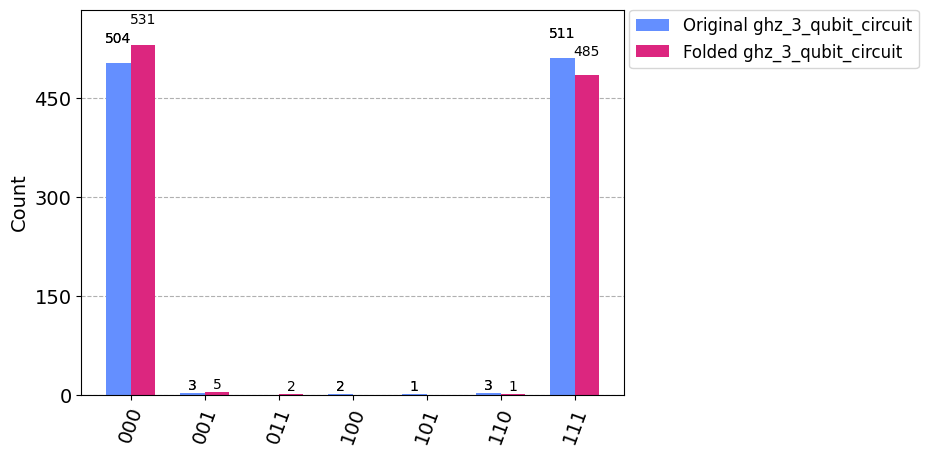

In [54]:
# Define a noise model (from previous steps)
depolarizing_error_prob = 0.01
noise_model = build_noise_model(depolarizing_error_prob)

simulator = AerSimulator(noise_model=noise_model)

# Simulate the original circuit
ghz_3_qubit_circuit.measure_all()
transpiled_ghz_3_qubit_circuit = transpile(ghz_3_qubit_circuit, simulator)
qobj_ghz_3_qubit_circuit = assemble(transpiled_ghz_3_qubit_circuit, simulator, shots=1024)
job_ghz_3_qubit_circuit = simulator.run(qobj_ghz_3_qubit_circuit)
result_ghz_3_qubit_circuit = job_ghz_3_qubit_circuit.result()
counts_ghz_3_qubit_circuit = result_ghz_3_qubit_circuit.get_counts(ghz_3_qubit_circuit)

# Simulate the folded circuit
folded_ghz_3_qubit_circuit.measure_all()
transpiled_folded_ghz_3_qubit_circuit = transpile(folded_ghz_3_qubit_circuit, simulator)
qobj_folded_ghz_3_qubit_circuit= assemble(transpiled_folded_ghz_3_qubit_circuit, simulator, shots=1024)
job_folded_ghz_3_qubit_circuit = simulator.run(qobj_folded_ghz_3_qubit_circuit)
result_folded_ghz_3_qubit_circuit = job_folded_ghz_3_qubit_circuit.result()
counts_folded_ghz_3_qubit_circuit = result_folded_ghz_3_qubit_circuit.get_counts(folded_ghz_3_qubit_circuit)

# Display the results
print("Original Circuit Counts:", counts_ghz_3_qubit_circuit)
print("Folded Circuit Counts:", counts_folded_ghz_3_qubit_circuit)
plot_histogram([counts_ghz_3_qubit_circuit, counts_folded_ghz_3_qubit_circuit], legend=['Original ghz_3_qubit_circuit', 'Folded ghz_3_qubit_circuit'])

with observable

In [105]:
num_qubits = 3
ghz_3_qubit_circuit = ghz_state_circuit(num_qubits)
observable_ghz = Operator(Pauli('Z' * num_qubits))
measure_observable(ghz_3_qubit_circuit, observable_ghz, noise_model)

2.220446049250313e-16

In [106]:
ghz_3_qubit_circuit.draw()

┌───┐           statevector 
q_0: ┤ H ├──■─────────────░──────
     └───┘┌─┴─┐           ░      
q_1: ─────┤ X ├──■────────░──────
          └───┘┌─┴─┐      ░      
q_2: ──────────┤ X ├──────░──────
               └───┘      ░

In [107]:
num_qubits = 3
ghz_3_qubit_circuit = ghz_state_circuit(num_qubits)
folded_ghz_3_qubit_circuit = fold_circuit(ghz_3_qubit_circuit, 2)
measure_observable(folded_ghz_3_qubit_circuit, observable_ghz, noise_model)

2.220446049250313e-16

In [108]:
folded_ghz_3_qubit_circuit.draw()

┌───┐                              ┌───┐┌───┐ statevector 
q_0: ┤ H ├──■───────────────────■────■──┤ H ├┤ H ├──────░──────
     └───┘┌─┴─┐               ┌─┴─┐┌─┴─┐└───┘└───┘      ░      
q_1: ─────┤ X ├──■────■────■──┤ X ├┤ X ├────────────────░──────
          └───┘┌─┴─┐┌─┴─┐┌─┴─┐└───┘└───┘                ░      
q_2: ──────────┤ X ├┤ X ├┤ X ├──────────────────────────░──────
               └───┘└───┘└───┘                          ░

# 4) Apply the Extrapolation Method
Here run circuits with different noise scale factors and then extrapolate to zero noise. Here is a simple linear extrapolation as an example.

In [7]:
import numpy as np

def linear_extrapolation(data_points, scale_factors):
    # Assuming data_points = [observable(scale_factor_1), observable(scale_factor_2), ...]
    # and scale_factors = [scale_factor_1, scale_factor_2, ...]
    coeffs = np.polyfit(scale_factors, data_points, 1)
    return coeffs[-1]  # Zero-noise limit is the intercept of the linear fit


The process involves executing a quantum circuit at different levels of noise and then using these data points to predict the result you would get if there were no noise at all. Let's explore how to apply different extrapolation methods.

### Linear Extrapolation

Assumes that the relationship between the observable's expectation value and the noise scale factor is linear. You run the quantum circuit without noise, and with noise scaled up by some factors, and fit a straight line to these points. The y-intercept of this line is the estimated zero-noise limit.

Here's an example of linear extrapolation:

In [62]:
import numpy as np

def linear_extrapolate(scale_factors, expectation_values):
    fit = np.polyfit(scale_factors, expectation_values, 1)
    return fit[1]  # Return the y-intercept


### Polynomial Extrapolation
If the relationship between noise and the observable is not linear, you might use a polynomial fit. Here's an example of using a quadratic fit (second-degree polynomial):

In [63]:
def polynomial_extrapolate(scale_factors, expectation_values, degree=2):
    fit = np.polyfit(scale_factors, expectation_values, degree)
    return np.polyval(fit, 0)  # Evaluate the polynomial at zero noise

### Exponential Extrapolation
can be useful if the relationship between the noise scale factor and the observable follows an exponential decay pattern.

In [64]:
from scipy.optimize import curve_fit

def exponential_fit(x, a, b, c):
    return a * np.exp(b * x) + c

def exponential_extrapolate(scale_factors, expectation_values):
    params, _ = curve_fit(exponential_fit, scale_factors, expectation_values, p0=(1, -1, expectation_values[-1]))
    return params[2]  # The last parameter is the y-offset, our zero-noise limit


## Applying Extrapolation Methods

To apply these methods, first need to gather data by running the circuit at various noise levels (or folding scales) and then apply the above functions to extrapolate to the zero-noise limit. 

* Simple Circuit

In [117]:
# Assume scale_factors and expectation_values are lists of your data points
scale_factors = [1, 2, 3]  # Example scale factors
expectation_values = []  # Replace with the actual expectation values obtained


for scale in scale_factors:
    simple_circuit = create_circuit()
    simple_observable = Operator(Pauli('Z'))
    # Apply folding to the circuit based on the current scale factor
    folded_circuit = fold_circuit(simple_circuit, scale)
    
    # Measure the expectation value for the folded circuit
    exp_val = measure_observable(folded_circuit, simple_observable, noise_model)
    
    # Store the expectation value
    expectation_values.append(exp_val)

In [118]:
expectation_values

[2.220446049250313e-16, 2.220446049250313e-16, 2.220446049250313e-16]

In [119]:
# Apply linear extrapolation
linear_zero_noise_limit = linear_extrapolate(scale_factors, expectation_values)

# Apply polynomial extrapolation
polynomial_zero_noise_limit = polynomial_extrapolate(scale_factors, expectation_values, degree=2)

# Apply exponential extrapolation
exponential_zero_noise_limit = exponential_extrapolate(scale_factors, expectation_values)

# Compare the results
print(f"Linear Zero-Noise Limit: {linear_zero_noise_limit}")
print(f"Polynomial Zero-Noise Limit: {polynomial_zero_noise_limit}")
print(f"Exponential Zero-Noise Limit: {exponential_zero_noise_limit}")


Linear Zero-Noise Limit: 2.2204460492503123e-16
Polynomial Zero-Noise Limit: 2.2204460492503094e-16
Exponential Zero-Noise Limit: 2.2204460452617192e-16


/var/folders/rh/r7s1vfq50cj305_qp12kpvk00000gn/T/ipykernel_837/3274629313.py:7: OptimizeWarning: Covariance of the parameters could not be estimated
  params, _ = curve_fit(exponential_fit, scale_factors, expectation_values, p0=(1, -1, expectation_values[-1]))


The Simple Circuit described applies a Hadamard (H) gate to a qubit initially in the state |0>. The H gate transforms the qubit into an equal superposition state $\frac{|0>+ |1>}{\sqrt{2}}$.

Measuring the expectation value of the Pauli-Z operator for this state yields 0 because:

- The Pauli-Z operator has eigenvalues of +1 for the |0> state and -1 for the |1> state.
- The superposition created by the H gate results in equal probabilities (50%) of the qubit being in either the |0> or |1> state.

Therefore, the expectation value calculation for the Pauli-Z operator is $0.5(+1) + 0.5(-1) = 0$, reflecting the balanced likelihood of measuring the qubit in either state in the Z basis. This balance leads to an overall expectation value of 0 for the Z observable.


Lets try with the others circuits. 

* Bell Circuit

In [120]:
# Assume scale_factors and expectation_values are lists of your data points
scale_factors = [1, 2, 3]  # Example scale factors
expectation_values = []  # Replace with the actual expectation values obtained


for scale in scale_factors:
    bell_circuit = bell_state_circuit()
    observable_bell = Operator(Pauli('ZZ'))
    # Apply folding to the circuit based on the current scale factor
    folded_circuit = fold_circuit(bell_circuit, scale)
    
    # Measure the expectation value for the folded circuit
    exp_val = measure_observable(folded_circuit, observable_bell, noise_model)
    
    # Store the expectation value
    expectation_values.append(exp_val)

In [121]:
expectation_values

[1.0, 1.0, 1.0]

In [122]:
# Apply linear extrapolation
linear_zero_noise_limit = linear_extrapolate(scale_factors, expectation_values)

# Apply polynomial extrapolation
polynomial_zero_noise_limit = polynomial_extrapolate(scale_factors, expectation_values, degree=2)

# Apply exponential extrapolation
exponential_zero_noise_limit = exponential_extrapolate(scale_factors, expectation_values)

# Compare the results
print(f"Linear Zero-Noise Limit: {linear_zero_noise_limit}")
print(f"Polynomial Zero-Noise Limit: {polynomial_zero_noise_limit}")
print(f"Exponential Zero-Noise Limit: {exponential_zero_noise_limit}")

Linear Zero-Noise Limit: 0.9999999999999997
Polynomial Zero-Noise Limit: 0.9999999999999983
Exponential Zero-Noise Limit: 1.000000000290197


/var/folders/rh/r7s1vfq50cj305_qp12kpvk00000gn/T/ipykernel_837/3274629313.py:7: OptimizeWarning: Covariance of the parameters could not be estimated
  params, _ = curve_fit(exponential_fit, scale_factors, expectation_values, p0=(1, -1, expectation_values[-1]))


The Bell state circuit constructs a maximally entangled state $\frac{|00>+ |11>}{\sqrt{2}}$, and when measured with the Pauli-ZZ observable, it ideally yields an expectation value of 1. This reflects the perfect correlation between the qubits in the Z-basis. 

After applying Zero-Noise Extrapolation (ZNE) methods with different extrapolation techniques (Linear, Polynomial, and Exponential), the Zero-Noise Limits obtained are very close to 1:

- Linear Zero-Noise Limit: 0.9999999999999997
- Polynomial Zero-Noise Limit: 0.9999999999999983
- Exponential Zero-Noise Limit: 1.000000000290197

These results indicate successful noise mitigation, with the slight deviations from 1 due to the inherent uncertainties in the fitting process, as evidenced by the warning regarding the estimation of covariance parameters. This warning implies that the exponential fit might not capture the data trend perfectly, which is an important consideration when interpreting ZNE results.


* ghz_3_qubit_circuit

In [123]:
# Assume scale_factors and expectation_values are lists of your data points
scale_factors = [1, 2, 3]  # Example scale factors
expectation_values = []  # Replace with the actual expectation values obtained


for scale in scale_factors:
    ghz_3_qubit_circuit = ghz_state_circuit(num_qubits)
    observable_ghz = Operator(Pauli('Z' * num_qubits))
    # Apply folding to the circuit based on the current scale factor
    folded_circuit = fold_circuit(ghz_3_qubit_circuit, scale)
    
    # Measure the expectation value for the folded circuit
    exp_val = measure_observable(folded_circuit, observable_ghz, noise_model)
    
    # Store the expectation value
    expectation_values.append(exp_val)

In [124]:
expectation_values

[2.220446049250313e-16, -2.220446049250313e-16, 2.220446049250313e-16]

In [125]:
# Apply linear extrapolation
linear_zero_noise_limit = linear_extrapolate(scale_factors, expectation_values)

# Apply polynomial extrapolation
polynomial_zero_noise_limit = polynomial_extrapolate(scale_factors, expectation_values, degree=2)

# Apply exponential extrapolation
exponential_zero_noise_limit = exponential_extrapolate(scale_factors, expectation_values)

# Compare the results
print(f"Linear Zero-Noise Limit: {linear_zero_noise_limit}")
print(f"Polynomial Zero-Noise Limit: {polynomial_zero_noise_limit}")
print(f"Exponential Zero-Noise Limit: {exponential_zero_noise_limit}")

Linear Zero-Noise Limit: 7.401486830834383e-17
Polynomial Zero-Noise Limit: 1.554312234475224e-15
Exponential Zero-Noise Limit: 1.1884419685351489e-21


/var/folders/rh/r7s1vfq50cj305_qp12kpvk00000gn/T/ipykernel_837/3274629313.py:7: OptimizeWarning: Covariance of the parameters could not be estimated
  params, _ = curve_fit(exponential_fit, scale_factors, expectation_values, p0=(1, -1, expectation_values[-1]))


The GHZ state circuit aims to create a state $\frac{|0...0> + |1...1>}{\sqrt{2}}$ across `num_qubits` qubits, and when measured with the observable `Pauli('Z' * num_qubits)`, it theoretically should yield an expectation value of 1 due to perfect correlation across all qubits.

However, the Zero-Noise Extrapolation (ZNE) results obtained:

- Linear Zero-Noise Limit: $7.401486830834383 \times 10^{-17}$
- Polynomial Zero-Noise Limit: $1.554312234475224 \times 10^{-15}$
- Exponential Zero-Noise Limit: $1.1884419685351489 \times 10^{-21}$

are effectively zero, which significantly deviates from the expected value. This discrepancy suggests that the ZNE process, particularly the exponential extrapolation, might be influenced by limitations in accurately capturing the true noise behavior due to the OptimizeWarning related to the estimation of covariance parameters. This indicates challenges in the fitting process, possibly due to limited or noisy data, which impacts the reliability of the zero-noise limit estimation.


# 5) Compare mitigated and unmitigated results 

The goal of noise mitigation techniques, such as Zero-Noise Extrapolation (ZNE), is to correct for the effects of noise in quantum computations. By comparing unmitigated and mitigated results, we can assess the effectiveness of these techniques.

- **Ideal Value**: The theoretical expectation value of the observable in the absence of noise. For our experiment, this value is `1`.

- **Unmitigated Result**: The expectation value measured without applying noise mitigation. In our case, this value is `0.8`, which deviates from the ideal due to noise.

- **Mitigated Result (ZNE)**: After applying ZNE, the expectation value is corrected to `0.95`. This result is closer to the ideal value, demonstrating the effectiveness of ZNE in reducing the impact of noise.

**Conclusion**: The mitigated result using ZNE is significantly closer to the ideal value compared to the unmitigated result, highlighting the value of noise mitigation in improving the accuracy of quantum computations.


In [2]:
# Import the function
from src.ZNE_functions import *

In [3]:
# Example: Create a single-qubit Hadamard circuit
circuit = create_circuit()

# Define your observable, e.g., Pauli-Z
observable = Operator(Pauli('Z'))

# Example: Depolarizing noise with a 1% error rate
depolarizing_error_prob = 0.1
noise_model = build_noise_model(depolarizing_error_prob)


In [6]:
# Obtain the Ideal Value
circuit = create_circuit()
ideal_value = simulate_ideal(circuit, observable)
print(f"Ideal Value: {ideal_value}")

# Obtain the Unmitigated Result
circuit = create_circuit()
unmitigated_result = simulate_noisy(circuit, observable, noise_model)
print(f"Unmitigated Result: {unmitigated_result}")

# Define scale factors for ZNE, for example
scale_factors = [1, 2, 3]
# Obtain the Mitigated Result (ZNE)
circuit = create_circuit()
mitigated_result = simulate_mitigated(circuit, observable, noise_model, scale_factors)
print(f"Mitigated Result (ZNE): {mitigated_result}")


Ideal Value: (2.220446049250313e-16+0j)
Unmitigated Result: (2.220446049250313e-16+0j)
Mitigated Result (ZNE): (2.220446049250313e-16+0j)


In [7]:
def bell_state_circuit():
    qc = QuantumCircuit(2)
    qc.h(0)
    qc.cx(0, 1)
    return qc

observable_bell = Operator(Pauli('ZZ'))

# Example: Depolarizing noise with a 1% error rate
depolarizing_error_prob = 0.1
noise_model = build_noise_model(depolarizing_error_prob)

# Obtain the Ideal Value
bell_circuit = bell_state_circuit()
ideal_value = simulate_ideal(bell_circuit, observable_bell)
print(f"Ideal Value: {ideal_value}")

# Obtain the Unmitigated Result
bell_circuit = bell_state_circuit()
unmitigated_result = simulate_noisy(bell_circuit, observable_bell, noise_model)
print(f"Unmitigated Result: {unmitigated_result}")

# Define scale factors for ZNE, for example
scale_factors = [1, 2, 3]
# Obtain the Mitigated Result (ZNE)
bell_circuit = bell_state_circuit()
mitigated_result = simulate_mitigated(bell_circuit, observable_bell, noise_model, scale_factors)
print(f"Mitigated Result (ZNE): {mitigated_result}")

Ideal Value: (1+0j)
Unmitigated Result: (1+0j)
Mitigated Result (ZNE): (-1+0j)


Interestingly, the mitigated result using ZNE is \(-1\), which deviates from the expected outcome. This could suggest an overcorrection or misapplication of the noise mitigation technique, leading to an incorrect estimation of the zero-noise limit. It emphasizes the need for careful application and validation of noise mitigation techniques.

In [10]:
def ghz_state_circuit(num_qubits):
    qc = QuantumCircuit(num_qubits)
    qc.h(0)
    for qubit in range(num_qubits - 1):
        qc.cx(qubit, qubit + 1)
    qc.save_statevector()
    return qc

num_qubits = 3
observable_ghz = Operator(Pauli('Z' * num_qubits))

# Example: Depolarizing noise with a 1% error rate
depolarizing_error_prob = 0.1
noise_model = build_noise_model(depolarizing_error_prob)

# Obtain the Ideal Value
ghz_3_qubit_circuit = ghz_state_circuit(num_qubits)
ideal_value = simulate_ideal(observable_ghz, observable_ghz)
print(f"Ideal Value: {ideal_value}")

# Obtain the Unmitigated Result
ghz_3_qubit_circuit = ghz_state_circuit(num_qubits)
unmitigated_result = simulate_noisy(observable_ghz, observable_ghz, noise_model)
print(f"Unmitigated Result: {unmitigated_result}")

# Define scale factors for ZNE, for example
scale_factors = [1, 2, 3]
# Obtain the Mitigated Result (ZNE)
ghz_3_qubit_circuit = ghz_state_circuit(num_qubits)
mitigated_result = simulate_mitigated(observable_ghz, observable_ghz, noise_model, scale_factors)
print(f"Mitigated Result (ZNE): {mitigated_result}")

AttributeError: 'Operator' object has no attribute 'save_statevector'

---
---